<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/NIFTY_ARIMA_and_GARCH_in_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install.packages(c("forecast", "rugarch", "quantmod", "tseries"))

# Load required packages

In [2]:
library(quantmod)    # For downloading stock data
library(forecast)    # For ARIMA modeling and forecasting
library(rugarch)     # For GARCH modeling
library(tseries)     # For stationarity test

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma




In [3]:
end_date <- Sys.Date()
start_date <- end_date - 365 * 5

In [4]:
# 1. Download Stock Data
# Download NIFTY stock data from Yahoo Finance.
# You can change the ticker symbol and date range as needed
symbol <- getSymbols("^NSEI", from = start_date, to = end_date, src = "yahoo", periodicity = "daily")

Warning message:
“^NSEI contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”


In [5]:
# Extract the Close price (or use Adjusted prices with Ad(NSEI))
close <- Ad(NSEI)

In [6]:
# 2. Compute the Logarithm of the Close Price
log_close <- log(close)

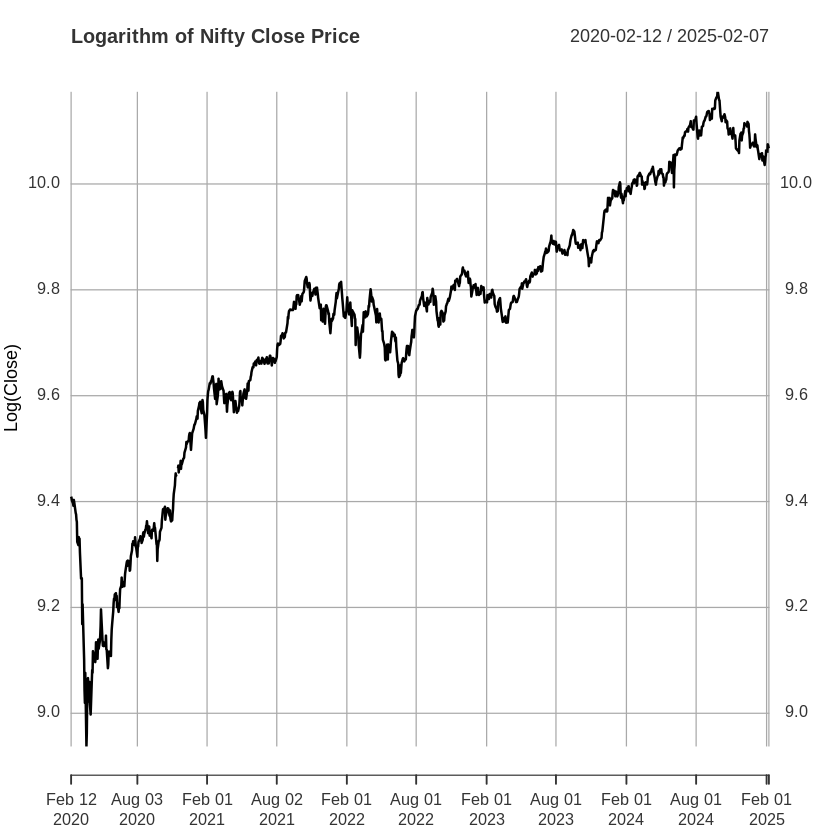

In [7]:
# Plot the log close prices
plot(log_close, main = "Logarithm of Nifty Close Price", ylab = "Log(Close)", xlab = "Date")

In [8]:
# Stock prices are typically non-stationary, so we use log returns
log_returns <- diff(log_close)
log_returns <- na.omit(log_returns)  # Remove the initial N

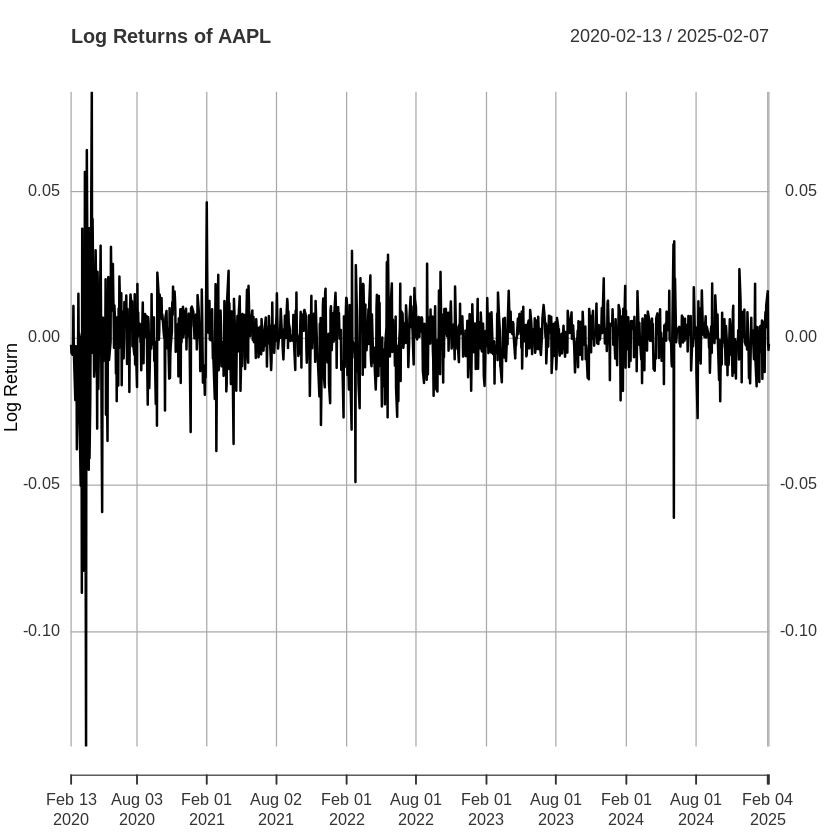

In [9]:
# Plot the log returns
plot(log_returns, main = "Log Returns of AAPL", ylab = "Log Return", xlab = "Date")

In [10]:
# 4. Check Stationarity (Augmented Dickey-Fuller Test)
adf_result <- adf.test(log_returns)
print(adf_result)
# A p-value < 0.05 indicates that the series is stationary

Warning message in adf.test(log_returns):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  log_returns
Dickey-Fuller = -10.576, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary



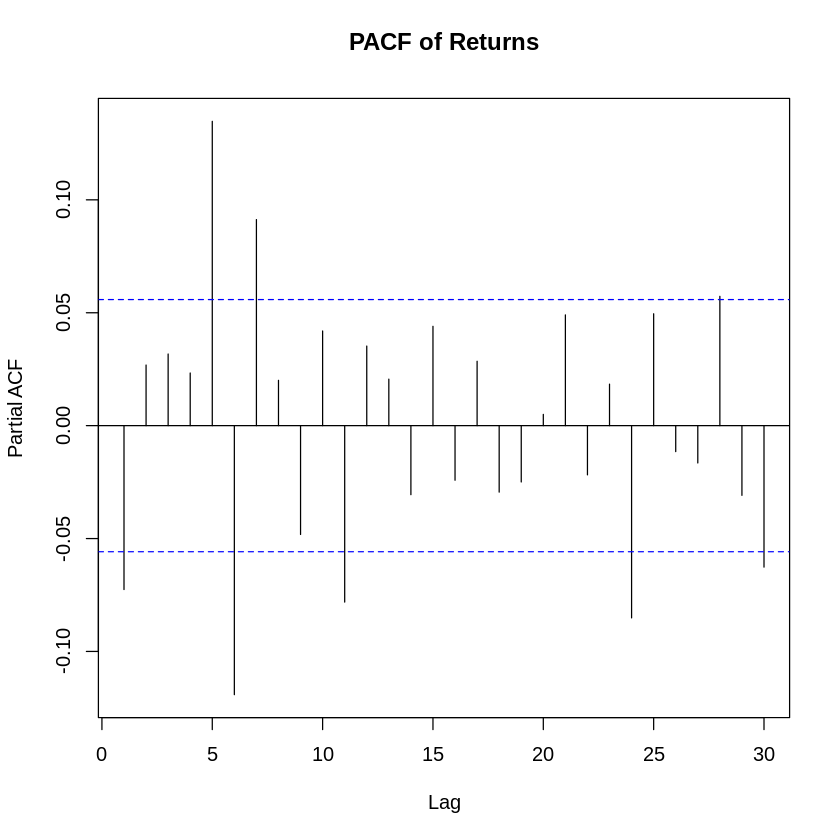

In [11]:
pacf(log_returns, main = "PACF of Returns")

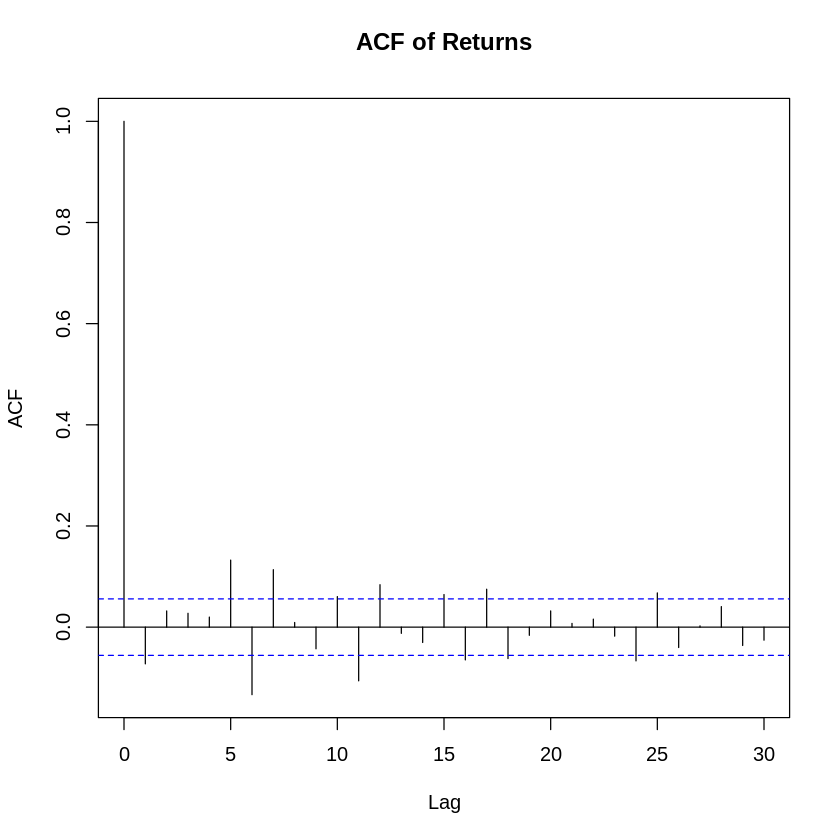

In [12]:
acf(log_returns, main = "ACF of Returns")

In [13]:
# 5. Fit an ARIMA Model on Log Returns
# auto.arima() will automatically choose the best ARIMA model for the data.
arima_model <- arima(log_returns, order = c(30, 0, 30))
print(summary(arima_model))


Call:
arima(x = log_returns, order = c(30, 0, 30))

Coefficients:


Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”


         ar1      ar2     ar3     ar4      ar5      ar6     ar7     ar8     ar9
      0.0657  -0.3479  0.1208  0.1369  -0.0326  -0.0410  0.4631  0.2578  0.0822
s.e.  0.0008      NaN     NaN     NaN      NaN   0.0001     NaN  0.0004     NaN
        ar10     ar11    ar12    ar13     ar14     ar15     ar16     ar17
      0.2157  -0.1771  0.1295  0.0502  -0.1122  -0.3153  -0.1256  -0.0362
s.e.     NaN   0.0005  0.0006  0.0007   0.0005   0.0001      NaN      NaN
         ar18    ar19     ar20    ar21    ar22    ar23     ar24    ar25
      -0.3088  0.1776  -0.1624  0.2223  0.1813  0.1762  -0.2415  0.2234
s.e.      NaN  0.0003      NaN     NaN  0.0002     NaN      NaN     NaN
         ar26    ar27    ar28     ar29    ar30      ma1     ma2      ma3
      -0.1190  0.0794  0.1838  -0.2198  0.0172  -0.0894  0.3772  -0.1276
s.e.   0.0003  0.0004  0.0002   0.0003  0.0001      NaN  0.0002      NaN
          ma4     ma5      ma6     ma7      ma8      ma9     ma10    ma11
      -0.0666  0.1403  -0.047


	Ljung-Box test

data:  Residuals from ARIMA(30,0,30) with non-zero mean
Q* = 47.891, df = 3, p-value = 2.246e-10

Model df: 60.   Total lags used: 63



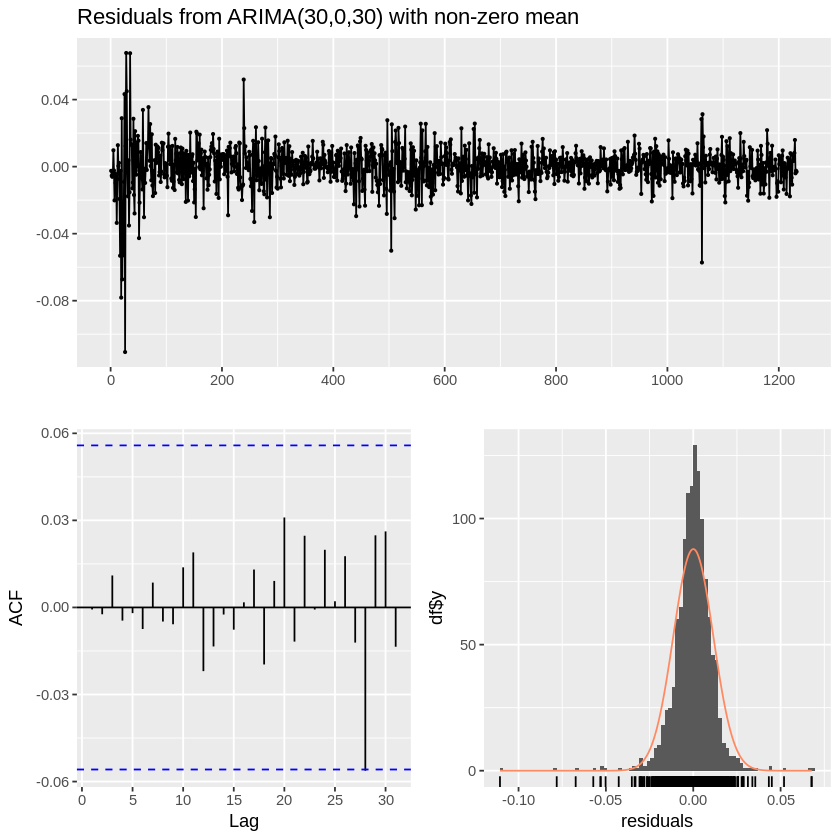

In [14]:
# Check the residuals of the ARIMA model
checkresiduals(arima_model)

In [15]:
# 6. Fit a GARCH Model on the ARIMA Residuals
# Volatility clustering in returns can be modeled with GARCH.
# We first extract the residuals from the ARIMA model.
arima_resid <- residuals(arima_model)

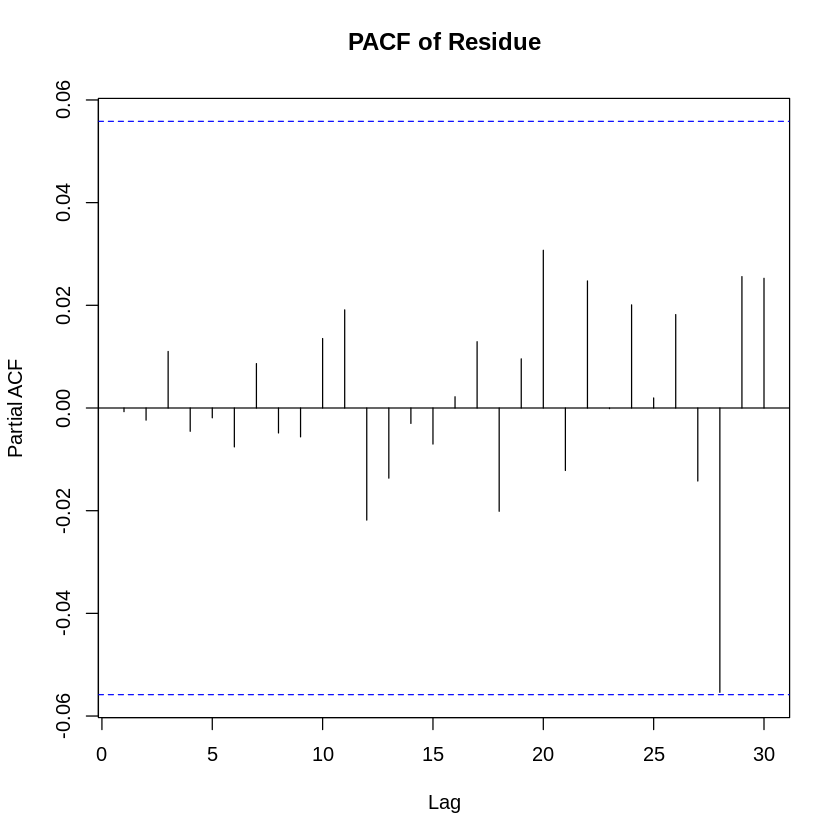

In [16]:
pacf(arima_resid, main = "PACF of Residue")

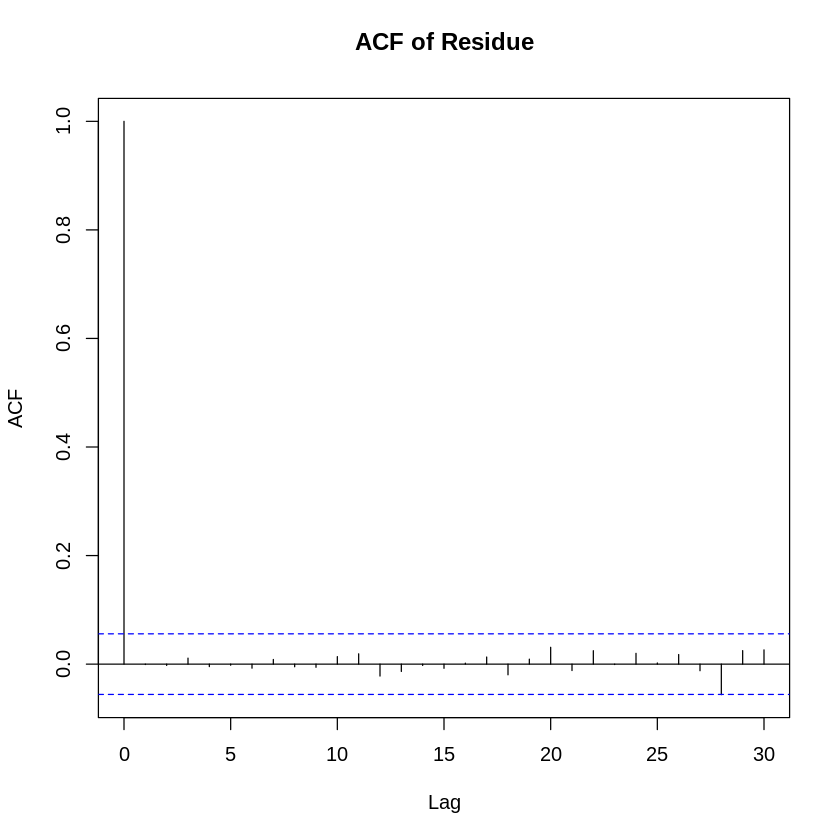

In [17]:
acf(arima_resid, main = "ACF of Residue")

In [18]:
# Specify a standard GARCH(1,1) model.
# Here, we model only the variance with GARCH; the mean model is assumed to be zero.
garch_spec <- ugarchspec(
  variance.model = list(model = "sGARCH", garchOrder = c(30, 30)),
  mean.model = list(armaOrder = c(0, 0), include.mean = TRUE),
  distribution.model = "std"  # Student's t-distribution to account for fat tails
)

In [19]:
# Fit the GARCH model to the ARIMA residuals
garch_fit <- ugarchfit(spec = garch_spec, data = arima_resid)
print(garch_fit)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(30,30)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
         Estimate  Std. Error  t value Pr(>|t|)
mu       0.000406    0.000288 1.409581 0.158663
omega    0.000015    0.000030 0.490408 0.623845
alpha1   0.139336    0.369612 0.376980 0.706189
alpha2   0.000000    0.017625 0.000004 0.999997
alpha3   0.021211    0.126342 0.167881 0.866677
alpha4   0.027732    0.311640 0.088989 0.929091
alpha5   0.019236    0.050976 0.377350 0.705913
alpha6   0.078053    0.043921 1.777129 0.075547
alpha7   0.017308    0.303553 0.057017 0.954531
alpha8   0.023090    0.011878 1.943931 0.051904
alpha9   0.059715    0.123999 0.481575 0.630108
alpha10  0.003630    0.115519 0.031427 0.974929
alpha11  0.000000    0.278947 0.000000 1.000000
alpha12  0.013717 

In [20]:
# Number of simulation periods (forecast horizon)
n_sim <- 200

In [21]:
# Number of simulated paths
n_paths <- 10000

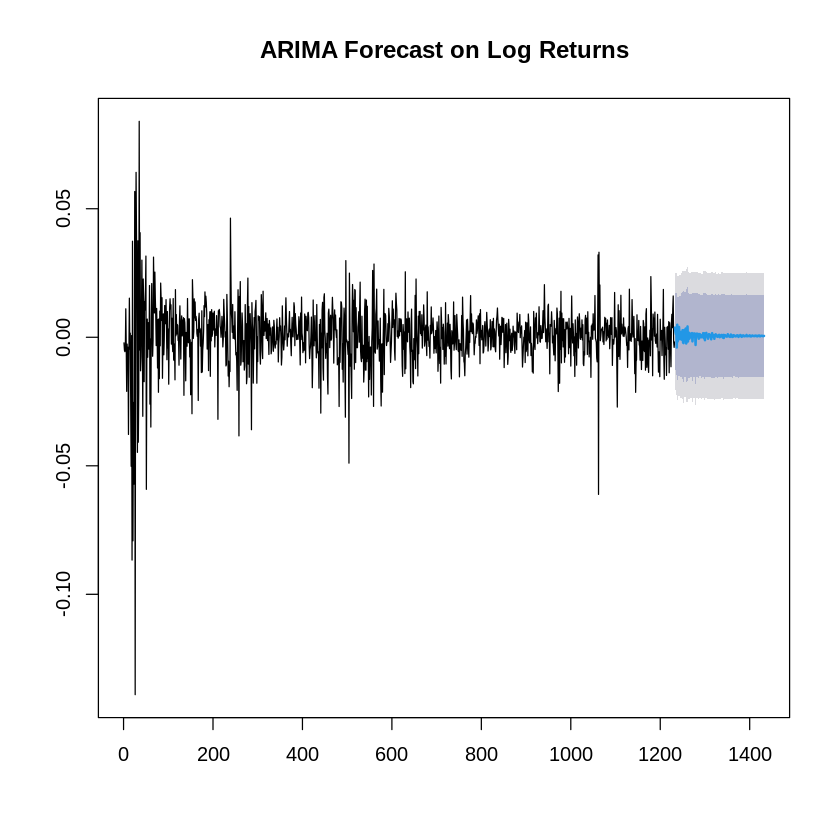

In [22]:
# 7. Forecasting
# Forecast 20 periods ahead using the ARIMA model.
arima_forecast <- forecast(arima_model, h = n_sim)
plot(arima_forecast, main = "ARIMA Forecast on Log Returns")

In [23]:
# Forecast the conditional volatility using the fitted GARCH model.
garch_forecast <- ugarchforecast(garch_fit, n.ahead = n_sim)

# Use sigma() to extract the forecasted volatility (conditional standard deviation)
garch_vol_forecast <- sigma(garch_forecast)

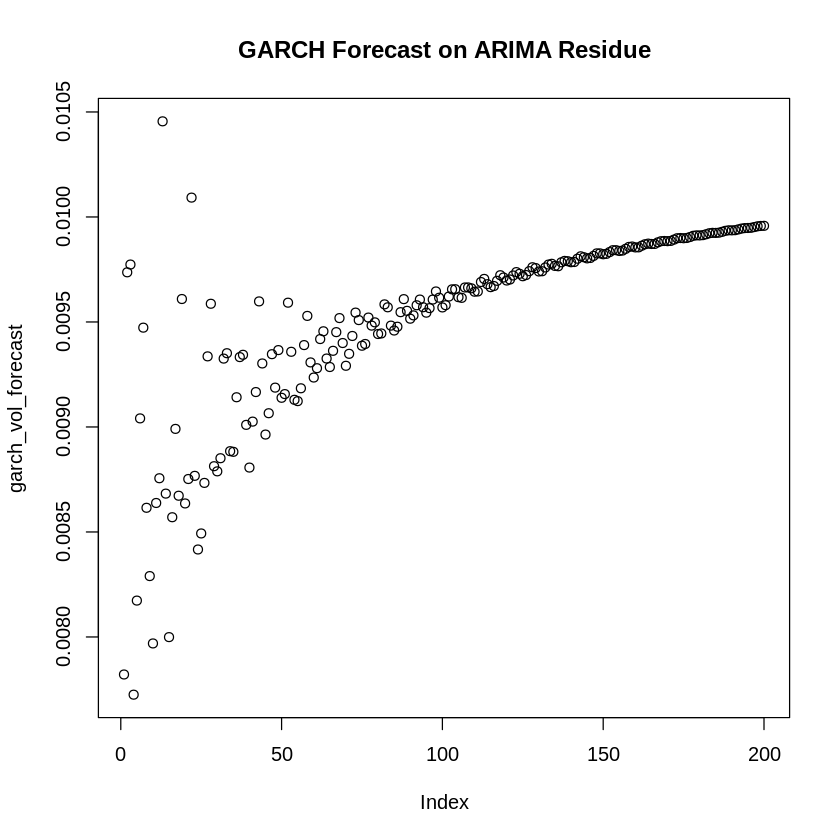

In [39]:
plot(garch_vol_forecast, main = "GARCH Forecast on ARIMA Residue")

In [24]:
S0 <- as.numeric(last(close))

In [25]:
# Extract the forecasted log return (drift) from the ARIMA model
# (Convert from time-series object to numeric vector)
arima_return_forecast <- as.numeric(arima_forecast$mean)

In [26]:
# Initialize a matrix to store simulated prices for each path.
# Rows: simulation steps (n_sim + 1 including starting price)
# Columns: simulation paths
sim_prices_matrix <- matrix(NA, nrow = n_sim + 1, ncol = n_paths)
sim_prices_matrix[1, ] <- S0  # Set the starting price for all paths

In [27]:
# Set seed for reproducibility
set.seed(123)

In [28]:
for (j in 1:n_paths) {
  for (i in 1:n_sim) {
    # Compute the simulated log return for the period:
    # forecasted drift - 0.5*(volatility^2) + (volatility * random shock)
    simulated_log_return <- arima_return_forecast[i] +
                              garch_vol_forecast[i] * rnorm(1)

    # Update the price using the GBM formula:
    # S_{t+1} = S_t * exp(simulated_log_return)
    sim_prices_matrix[i + 1, j] <- sim_prices_matrix[i, j] * exp(simulated_log_return)
  }
}

In [29]:
sample_path = sim_prices_matrix[, 1:15]

In [30]:
# Create a time index for simulation output.
# Starting at the last available date from the observed data.
last_date <- index(close)[length(close)]
sim_dates <- seq.Date(from = last_date, by = "days", length.out = n_sim + 1)

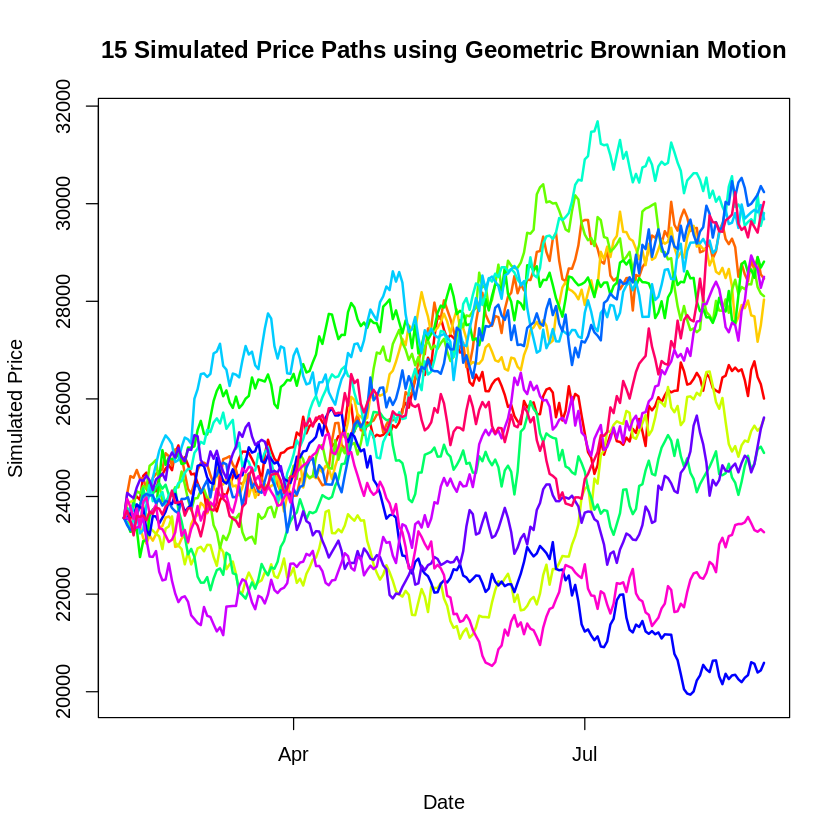

In [31]:
# Plot the simulated paths using different colors for each path.
matplot(sim_dates, sample_path, type = "l", lty = 1, lwd = 2,
        col = rainbow(15), xlab = "Date", ylab = "Simulated Price",
        main = "15 Simulated Price Paths using Geometric Brownian Motion")

In [32]:
# For VaR, we examine the distribution of terminal (final) simulated prices.
final_prices <- sim_prices_matrix[n_sim + 1, ]

In [33]:
return_percent = 100 * (final_prices - S0) / S0

    2.5%      25%      50%      75%    97.5% 
20251.63 24045.30 26316.77 28801.82 34471.03 


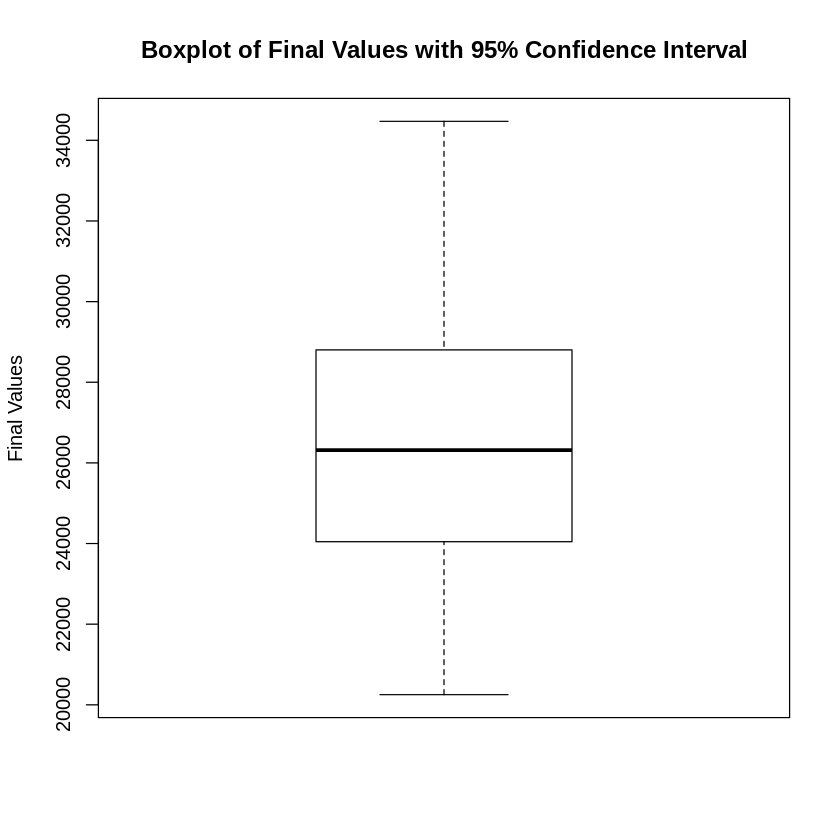

In [34]:
q_values <- quantile(final_prices, probs = c(0.025, 0.25, 0.5, 0.75, 0.975))
print(q_values)

stats <- matrix(as.numeric(q_values), ncol = 1)

bp <- list(
    stats = stats,
    n = length(final_prices),
    conf = matrix(NA, ncol = 1, nrow = 2),  # Not used in this example
    out = numeric(0),
    group = numeric(0),
    names = "Final Values"
)

bxp(bp, main = "Boxplot of Final Values with 95% Confidence Interval",
    ylab = "Final Values")

      2.5%        25%        50%        75%      97.5% 
-14.042111   2.060049  11.701289  22.249090  46.311973 


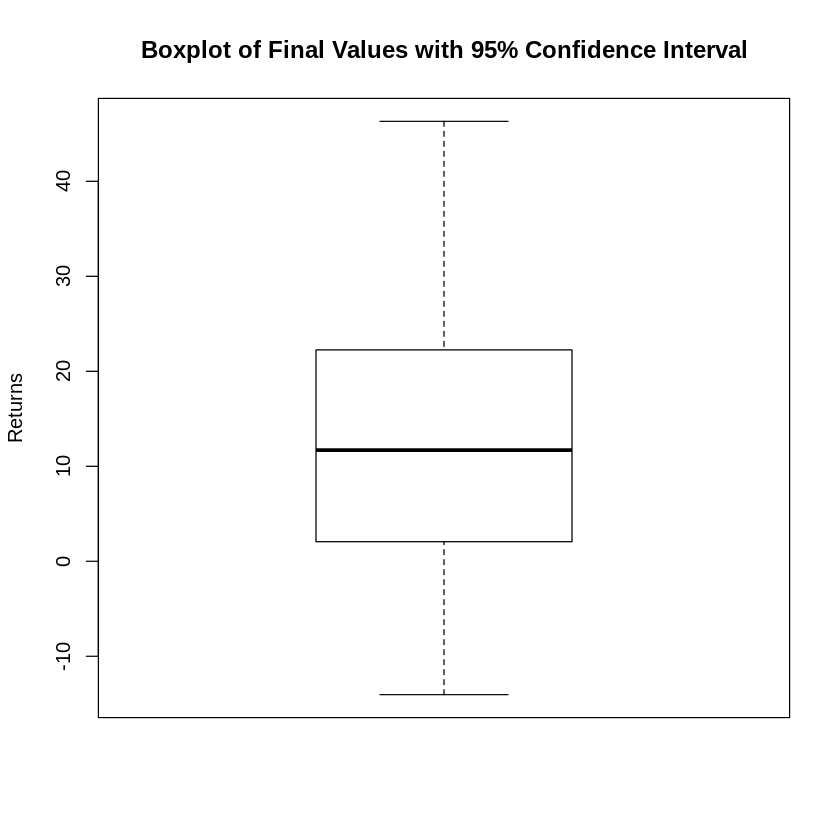

In [35]:
q_values <- quantile(return_percent, probs = c(0.025, 0.25, 0.5, 0.75, 0.975))
print(q_values)

stats <- matrix(as.numeric(q_values), ncol = 1)

bp <- list(
    stats = stats,
    n = length(return_percent),
    conf = matrix(NA, ncol = 1, nrow = 2),  # Not used in this example
    out = numeric(0),
    group = numeric(0),
    names = "Returns"
)

bxp(bp, main = "Boxplot of Final Values with 95% Confidence Interval",
    ylab = "Returns")

In [36]:
value_at_risk = quantile(return_percent, probs = 0.05)

In [37]:
value_at_risk

5% 
-10.27713